<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###All important libraries/modules that may be needed:
1. torchvision
2. torchvision.datasets: has a range of toy datasets for different purposes
3. torchvision.models:
4. torchvision.transforms
5. torch.utils.data.Dataset
6. torch.utils.data.Dataloader

In [ ]:
!pip install torchmetrics


In [ ]:
#getting libraries
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#import matplotlib
import matplotlib.pyplot as plt

#import accuracy fuction
from torchmetrics.classification import MulticlassAccuracy

#chacking versions
print("PyTorch version:", torch.__version__, "Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0+cu121 Torchvision version: 0.16.0+cu121


####Getting Training and Testing Data from Torchvision.datasets

In [ ]:
train_data=datasets.FashionMNIST(root="Fashion_Data",#telling where to store the data
                          train=True,#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this#not necessary to use here as we are just assigning None value to it(labels dont need transformation)
                          )
test_data=datasets.FashionMNIST(root="Fashion_Data",#telling where to store the data
                          train=False,#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this
                          )

In [ ]:
data, label= train_data[12]
data.shape, label #output tells shape of data and the label which is an integer
#first index of shape gives number of colour channels, if its 3 then image is in RGB

(torch.Size([1, 28, 28]), 5)

Checking Length of Train and Test dataset

In [ ]:
train_data.__len__(),test_data.__len__() #find dataset specific methods from source code

(60000, 10000)

In [ ]:
class_names=train_data.classes #returns a list of names of classes

Printing the data in dataset labels

In [ ]:
labels=[]
for i in range(train_data.__len__()):
  data,label=train_data[i]
  labels.append(label)
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Visualizing Data

Image Shape:torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Bag')

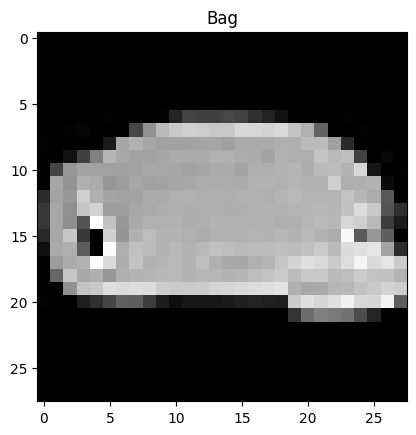

In [ ]:
import matplotlib.pyplot as plt
image,label=train_data[5555]
print(f"Image Shape:{data.shape}")
image=image.view(image.shape[1],image.shape[2], image.shape[0])#putting colour map in  the last index so imshow doesnt show any error
plt.imshow(image, cmap='gray')
plt.title(class_names[label])

Making Batches


In [ ]:
from torch.utils.data import DataLoader
#for large datasets its computationally faster to work in batches rather than working with individual datasets
#setting batch size hyperparameter
BATCH_SIZE= 32

train_dataloader=DataLoader(train_data,#target dataset
                            batch_size=BATCH_SIZE,#batch size
                            shuffle=True)#whether to shuffle the datapoints or not so that neural network does not get trained on some unobvious pattern present in ordering of data points
test_dataloader=DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)#can make it shuffle but its not necessary and will add another calculation step in every epoch
print(train_dataloader, test_dataloader)
print(len(train_dataloader), len(test_dataloader))


<torch.utils.data.dataloader.DataLoader object at 0x7ec638d164d0> <torch.utils.data.dataloader.DataLoader object at 0x7ec638d16e90>
1875 313


In [ ]:
#checking data inside data loader
train_features_batch, train_labels_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

###Build a baseline model
A baseline model is the simplest model which you start with before progressing to more complicated ones.

Here, model has one difference from previous models. A nn.Flatten layer is used to convert the data in 2 dimensions (of the image ) to one feature vector.
The data in format[C,H,W] gets converted to [C,H*W].
This is done because nn.Linear layer works better with vectors

In [ ]:
#to see how flatten layer works, create a flatten layer
flatten_layer=nn.Flatten()
x=train_features_batch[0]
output=flatten_layer(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
#building the baseline model
from torch import nn
class Fashion_Model_0(nn.Module):
  def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
    super().__init__()
    self.layers=nn.Sequential(nn.Flatten(),
                              nn.Linear(in_features=input_shape, out_features= hidden_units),
                              nn.Linear(in_features=hidden_units, out_features= output_shape))
  def forward(self,x):
    return self.layers(x)

Making first instance of the model

In [ ]:
model_0=Fashion_Model_0(input_shape=784,#as images here are 28x28=784, its hardcoded in this model
                        hidden_units=50,
                        output_shape=len(class_names))#output units will give one logit for wach member of class names
model_0.to('cpu')#keep model in cpu to begin with

Fashion_Model_0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

Defining Accuracy, Loss function and Optimizer

In [ ]:
accuracy=MulticlassAccuracy(num_classes=len(class_names))
loss_fn=nn.CrossEntropyLoss()#same as multiclass classification loss function
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)#SGD optimizer

Defining function to measure time taken for training model

In [ ]:
from timeit import default_timer as timer
def print_train_time(start:float, end: float, device: torch.device=None):

  """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

Making training and testing loop

In [ ]:
!pip install tqdm # for showing progress meter

In [ ]:
from tqdm.auto import tqdm
epochs=3#keep small at first for smaller loop time
#set random seed
torch.manual_seed(56)
#start the timer
train_start_cpu=timer()

for epoch in tqdm(range(epochs)):
  print("Epoch:", epoch)
  ##Training
  train_loss=0
  train_acc=0
  model_0.train() #put in training mode
  #loop through training batches
  for batch,(x,y) in enumerate(train_dataloader):
    #1. Forward Pass
    y_pred=model_0(x)

    #2. Calculate Loss and Accuracy
    loss= loss_fn(y_pred, y)
    train_loss+=loss#add up the loss of each sample in the batch to get loss of whole batch
    acc=accuracy(y, y_pred.argmax(dim=1))
    train_acc+=acc
    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. Loss Backward
    loss.backward()

    #5. Optimizer Step
    optimizer.step()

    if batch%200==0:
      amount=(batch * len(x))/len(train_dataloader.dataset)
      print("Looked at", amount, "samples")
  train_loss/=len(train_dataloader)
  train_acc/=len(test_dataloader)#FOR SOME REASON TRAINING ACCURACY COMING AS HIGHER THAN 100%, SO ITS PROBABLY NOT A RELIABLE METRIC IN THIS CASE
  #Testing
  test_loss,test_acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for x,y in test_dataloader:
      #forward pass
      test_pred= model_0(x)

      #calculate accumulative loss
      test_loss+=loss_fn(test_pred,y)

      #calculate accumulative accuracy
      test_acc+=accuracy(y, test_pred.argmax(dim=1))
    #NOTE: Calculations of test metrics should be done in inference mode
    #calculating average loss and accuracy
    test_loss/=len(test_dataloader)
    test_acc/= len(test_dataloader)
  #print out whats happening
  print("Training Loss:", train_loss.item(), "Training Accuracy:", (train_acc.item())*100,"%", "Test Loss:", test_loss.item(), "Test Accuracy:", (test_acc.item()*100),"%")

#calculate training
train_end_cpu=timer()
total_train_time_model_0=print_train_time(start=train_start_cpu,
                                           end=train_end_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0.0 samples
Looked at 0.10666666666666667 samples
Looked at 0.21333333333333335 samples
Looked at 0.32 samples
Looked at 0.4266666666666667 samples
Looked at 0.5333333333333333 samples
Looked at 0.64 samples
Looked at 0.7466666666666667 samples
Looked at 0.8533333333333334 samples
Looked at 0.96 samples
Training Loss: 0.575770914554596 Training Accuracy: 468.3789253234863 % Test Loss: 0.5047078728675842 Test Accuracy: 80.76925277709961 %
Epoch: 1
Looked at 0.0 samples
Looked at 0.10666666666666667 samples
Looked at 0.21333333333333335 samples
Looked at 0.32 samples
Looked at 0.4266666666666667 samples
Looked at 0.5333333333333333 samples
Looked at 0.64 samples
Looked at 0.7466666666666667 samples
Looked at 0.8533333333333334 samples
Looked at 0.96 samples
Training Loss: 0.47106435894966125 Training Accuracy: 492.6476001739502 % Test Loss: 0.497261106967926 Test Accuracy: 81.49677515029907 %
Epoch: 2
Looked at 0.0 samples
Looked at 0.10666666666666667 samples
Looked a

Functionalizing training, testing and evaluation of the model

In [ ]:
#following function returns the name, loss and accuracy of model provided in input
def evaluate_model(model:torch.nn.Module,
                   data_loader: torch.utils.data.DataLoader,
                   loss_fn:torch.nn.Module,
                   accuracy_fn,
                   device:torch.device):#will write device agnostic code below
  loss,acc=0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for x,y in data_loader:
      #send data to selected device
      x,y=x.to(device), y.to(device)
      #making preductions
      y_pred=model(x)
      #accumulating loss and accuracy
      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y,y_pred.argmax(dim=1))
    #calculate average loss and accuracy per batch
    loss/=len(data_loader)
    acc/=len(data_loader)

    return {"model name": model,
            "model loss": loss.item(),
            "model accuracy": str(acc.item()*100)+"%"}

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#testing on model_0
model_0_results=evaluate_model(model=model_0,data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy,device=device)
model_0_results

{'model name': Fashion_Model_0(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=50, bias=True)
     (2): Linear(in_features=50, out_features=10, bias=True)
   )
 ),
 'model loss': 0.4659469425678253,
 'model accuracy': '82.2830319404602%'}

In [ ]:
def training_step(model:torch.nn.Module,
                  data_loader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                  optimizer:torch.optim.Optimizer,
                  accuracy_fn, device:torch.device):
  train_loss,train_acc=0,0
  model.to(device)
  model.train()#put in training mode
  for batch, (x,y) in enumerate(data_loader):
    #send data to selected device
    x,y=x.to(device), y.to(device)

    #Forward Pass
    y_pred=model(x)

    #calculate loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_pred.argmax(dim=1),y)#going from logits to predicte dlabels to calculate accuracy

    #optimizer zero grad
    optimizer.zero_grad()

    #Loss Backward
    loss.backward()

    #optimizer step
    optimizer.step()

  #calculate loss and accuracy per epoch
  train_loss/=len(data_loader)
  train_acc/= len(data_loader)

  print("Train Loss:", train_loss.item(), "Train Accuracy:", train_acc.item())

In [ ]:
def testing_step(model:torch.nn.Module,
                  data_loader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                 accuracy_fn, device:torch.device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()#put in evaluation mode
  with torch.inference_mode():
    for batch, (x,y) in enumerate(data_loader):
      #send data to selected device
      x,y=x.to(device), y.to(device)

      #Forward Pass
      test_pred=model(x)

      #calculate loss
      loss=loss_fn(test_pred,y)
      test_loss+=loss
      test_acc+=accuracy_fn(test_pred.argmax(dim=1),y)#going from logits to predicte dlabels to calculate accuracy
    #calculating average loss and accuracy for whole epoch
    test_loss/=len(data_loader)
    test_acc/= len(data_loader)
  print("Test Loss:", test_loss.item(), "Test Accuracy:", test_acc.item())

Setting up device agnostic code

Building a better model

In [ ]:
class Fashion_Model_1(nn.Module):
  def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
    super().__init__()
    self.layers=nn.Sequential(nn.Flatten(),
                              nn.Linear(in_features=input_shape, out_features= hidden_units),
                              nn.ReLU(),
                              nn.Linear(in_features=hidden_units, out_features= output_shape),
                              nn.ReLU())
  def forward(self,x:torch.Tensor):
    return self.layers(x)

Intantiating new model

In [ ]:
model_1=Fashion_Model_1(input_shape=784,#as images here are 28x28=784, its hardcoded in this model
                        hidden_units=50,
                        output_shape=len(class_names))#output units will give one logit for wach member of class names
model_1.to(device)


Fashion_Model_1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
accuracy=MulticlassAccuracy(num_classes=len(class_names)).to(device)
loss_fn=nn.CrossEntropyLoss()#same as multiclass classification loss function
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.25)#SGD optimizer

In [ ]:
#training model_1
epochs=3#keep small at first for smaller loop time
#set random seed
torch.manual_seed(56)
#start the timer
model_1_train_start=timer()

for epoch in tqdm(range(epochs)):
  print("Epoch:", epoch)
  training_step(data_loader=train_dataloader,
             model=model_1,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy,
                device=device)
  testing_step(data_loader=test_dataloader,
             model=model_1,
             loss_fn=loss_fn,
             accuracy_fn=accuracy,
               device=device)
model_1_train_end=timer()
train_time_model_1=print_train_time(end=model_1_train_end,start=model_1_train_start,device=device)
#on cpu 3 epochs taking approx 35 sec
# on gpu T4 also, it taks approx 35.5 seconds
#gpu might not significantly lower the time taken for small number of epochs because some amount of time goes in transferring data from cpu to gpu

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.651090681552887 Train Accuracy: 0.7574836611747742
Test Loss: 0.4628470838069916 Test Accuracy: 0.8203873634338379
Epoch: 1
Train Loss: 0.4280920624732971 Train Accuracy: 0.83262038230896
Test Loss: 0.46356722712516785 Test Accuracy: 0.8229556083679199
Epoch: 2
Train Loss: 0.39064502716064453 Train Accuracy: 0.8465279936790466
Test Loss: 0.4322686195373535 Test Accuracy: 0.8387128114700317
Train time on cuda: 35.567 seconds


In [ ]:
model_1_results = evaluate_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy,
    device=device)
model_1_results,model_0_results

({'model name': Fashion_Model_1(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=50, bias=True)
      (2): ReLU()
      (3): Linear(in_features=50, out_features=10, bias=True)
      (4): ReLU()
    )
  ),
  'model loss': 0.4322686195373535,
  'model accuracy': '83.62743258476257%'},
 {'model name': Fashion_Model_0(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=50, bias=True)
      (2): Linear(in_features=50, out_features=10, bias=True)
    )
  ),
  'model loss': 0.4659469425678253,
  'model accuracy': '82.2830319404602%'})

Building a CNN

In [ ]:
#Basic Structure
#Input Layer-> [Convolutional Layer -> Activation Layer -> Pooling Layer] -> Output Layer
#The network in bracket can be scaled and modified depending on the problem
#Remember : conv2d layer takes 4 dimensional tensor, first dimension representing number of image in the specific batch
class Fashion_Model_2(nn.Module):
  def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
    super().__init__()
    self.block_1= nn.Sequential(
        nn.Conv2d(in_channel=input_shape,
                  out_channel=hidden_units,
                  kernel_size=3,
                  stride=1,# 1 is default
                  padding='same'),#options= "same" so output has same dimensions as input or "valid" for no padding
        nn.ReLU(),
        nn.Conv2d(in_channel=hidden_units,
                  out_channel=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,#kernels will be of size 2x2
                     stride=2)
    )
    self.block_2=nn.Sequential(
        nn.Conv2d(in_channel=hidden_units,
                  out_channel=hidden_units,
                  kernel_size=3,
                  padding='same')
        nn.ReLU(),
        nn.Conv2d(in_channel=hidden_units,
                  out_channel=hidden_units,
                  kernel_size=3,
                  padding='same')
        nn.ReLU(),
        nn.MaxPool2d(2)# by default kernel size and stride are taken to be equal

    )
    self.Classifier=nn.Sequential(
        nn.Flatten()
        nn.Linear(in_features=hidden_units*7*7,#avoid hardcoding here use len() on the flattened vector to input no. of in_features
                  out_features=output_shape)
    )
    def forward(x):
      #print(f"initial shape:{x.shape}")
      x=self.block_1(x)
      #print(f"Shape after block 1 is:{x.shape}")
      self.block_2(x)
      #print(f"Shape after block 2 is:{x.shape}")
      x= self.Classifier(x)
      #print(f"Shape after classifier layer is:{x.shape}")
      return x
#have set padding as same so size of image does not change
#instantiating a model
model_2= Fashion_Model_2(input_shape=1, hidden_units=6, output_shape=len(class_names).to(device))#len() would be done in cpu so need to shift to device
model_2

Setting Loss function and Optimizer function

In [ ]:
accuracy=MulticlassAccuracy(num_classes=len(class_names)).to(device)
loss_fn=nn.CrossEntropyLoss()#same as multiclass classification loss function
optimizer=torch.optim.SGD(params=model_2.parameters(), lr=0.25)#SGD optimizer

Training model_2

In [ ]:
#training model_2
epochs=3#keep small at first for smaller loop time
#set random seed
torch.manual_seed(56)
#start the timer
model_2_train_start=timer()

for epoch in tqdm(range(epochs)):
  print("Epoch:", epoch)
  training_step(data_loader=train_dataloader,
             model=model_2,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy,
                device=device)
  testing_step(data_loader=test_dataloader,
             model=model_2,
             loss_fn=loss_fn,
             accuracy_fn=accuracy,
               device=device)
model_2_train_end=timer()
train_time_model_1=print_train_time(end=model_2_train_end,start=model_2_train_start,device=device)

In [ ]:
#evaluating model results
model_2_results = evaluate_model(model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy,
    device=device)
model_2_results,model_1_results, model_0_results